# Let's <font color='af0606'>YELP</font> to Open Restaurants

### Team 8

Dongzhe Zhang, Fernanda Lin, Hongyang Liu, Lyufan Pan and Mansi Tolia

## <font color='af0606'>Our Dataset:</font>

We have used the [Yelp](https://www.kaggle.com/yelp-dataset/yelp-dataset/version/6) dataset from Kaggle, which is a subset of Yelp's businesses, reviews, and user data. 

It gives us information about businesses across 11 metropolitan areas in 4 countries. 

In [8]:
%%bq query -n Restaurant_number_piechart

SELECT
  category_name,
  COUNT(*) AS number
FROM (
  SELECT
    business_id,
    name,
    SPLIT(categories,";") AS category
  FROM
    `team-8-bs-770-b.Yelp.Yelp_business`),
  UNNEST( category ) AS category_name
GROUP BY category_name
ORDER BY number DESC
LIMIT 5

# First, we clean the data from the "Yelp_business" database and unnest the array of category column of each business. 
# Then we select the name and the number of categories using group by. 
# The output gives us the total number of businesses present in the top 5 business categories.

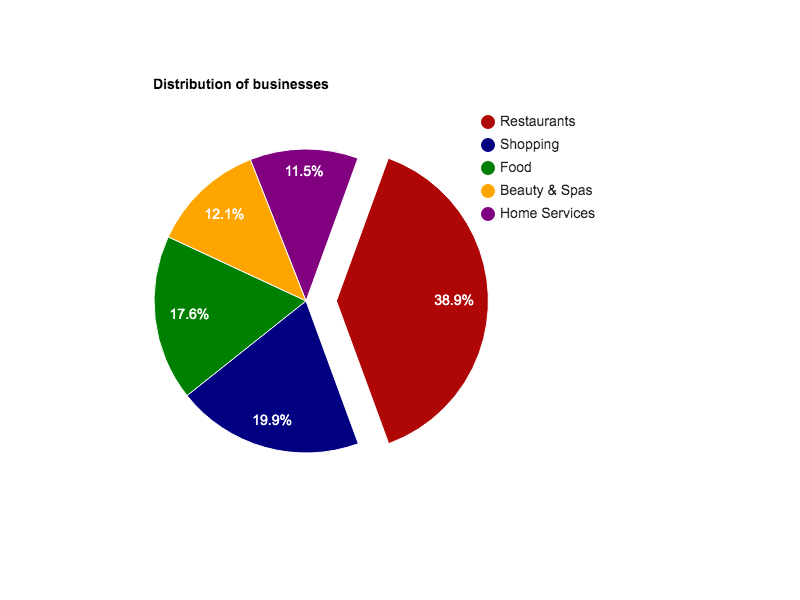

In [9]:
%%chart pie --data Restaurant_number_piechart

title: Distribution of businesses
colors: ['af0606', 'navy', 'green', 'orange', 'purple']
height: 600
width: 800
pieStartAngle: 20
slices:
    0:
        offset: .2

From the output and the pie chart, **"Restaurants"** is clearly the most prevalent business in the database, which comprises 38.9% of the top 5 categories - which is more than double of the second category "Shopping". This is the reason we only decided to focus on businesses which belong to the category "restaurants".

NOTE: The category "Food" is an atypical category. Restaurants, shopping and other category of business may contain the "Food" category.

## <font color='af0606'>Business Problem:</font>

Our **aim** is to recommend to investors:

1. Top **3 cities** to open restaurants in

2. Unique combination of possible **cuisines and attributes** that would make the restaurant popular in each city respectively 

We will be basing these recommendations on **star ratings, check-ins and feedback** given by the customers.




## <font color='af0606'>Quick Look:</font>

Here is a quick look at the 4 tables we used for this analysis:

**1.** The **"Yelp_business"** table which gave us basic information about the restaurants.

In [49]:
%%bq query

SELECT * 
FROM `team-8-bs-770-b.Yelp.Yelp_business` 
WHERE categories LIKE ('%Restaurants%')
LIMIT 5

business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
ppoOoE1YTERcWdFfh25qHQ,"""Upper Crust Famously Fresh Baguettes""",,"""Toronto Pearson International Airport, Terminal 1, After-Security (USA), Level 2 Gates.""",Mississauga,ON,,43.6799150875,-79.6119010448,2.0,15,1,Sandwiches;Restaurants
ECUSa_fHQVLvG5Dg2d0M5w,"""Burger King""",Saint-Laurent,"""Pierre Elliott Trudeau Airport""",Montréal,QC,,45.4561357168,-73.7528663707,2.0,4,1,Restaurants;Fast Food
a2Kt_hXNlBIM_ZlpUVfm2A,"""Gourmet Bitches""",Downtown Core,"""""",Toronto,ON,,43.653226,-79.3831843,2.0,13,1,Restaurants;Food Stands
RGVanstTVdGptTJD-FQTpw,"""Cabine M""",Dorval,"""Zone Internationale de l'aéroport Montréal-Trudeau, porte 52, Restaurant de Louis François Marcotte.""",Dorval,QC,,45.45,-73.75,2.0,4,1,Restaurants
2aWV8Rx4TwtB0x2pfIPNxA,"""Restaurant Houston Steaks et Cotes Levees""",Dorval,"""Aeroport Trudeau Montreal, US Departures Side""",Dorval,QC,,45.4560993506,-73.7531246953,2.0,73,1,Restaurants;Steakhouses


**2.** The **"Yelp_Checkins"** table which gave us information about the number of checkins at restaurants.

In [52]:
%%bq query

SELECT * 
FROM `team-8-bs-770-b.Yelp.Checkins`
LIMIT 5

business_id,weekday,hour,checkins
uU8up3hGwW9qnzQD1HZsMQ,Fri,0:00,1
rXUZNVlpWMV5ORDDSguOEQ,Fri,0:00,3
0Myf2fOlXXNHgIuPZoOlsA,Fri,0:00,2
mc5Ha4QyQZvU7fzr-ubhhw,Fri,0:00,5
u0wSFmWfg7IFJRl-WdSrNQ,Fri,0:00,1


**3.** The **"Attributes"** table which gave us information about what attribute/service is provided by each restaurants.

In [51]:
%%bq query

SELECT * 
FROM `team-8-bs-770-b.Yelp.Attributes` 
LIMIT 5

business_id,BusinessAcceptsCreditCards,BusinessParking_garage,WheelchairAccessible,BikeParking,Alcohol,RestaurantsReservations,HappyHour,OutdoorSeating
UlI0TksGFiIXtcbtg2KalQ,Na,Na,Na,Na,Na,Na,Na,FALSE
NS6sflNa3aqP74iDzIDB9g,Na,Na,Na,Na,Na,Na,TRUE,Na
fHCf4N3K7Ul8TLj6z5CKFQ,Na,Na,Na,Na,TRUE,Na,Na,Na
gXjcL8ZDCpFG1J8pxaxdFA,Na,Na,Na,Na,Na,free,Na,Na
R06MTQpLNdsnr5wrCkMXfQ,Na,Na,Na,Na,Na,Na,Na,Na


**4.** The **"Yelp_reviews"** table which gave us information about what feedback customers have left for each of the restaurants.

In [3]:
%%bq query

SELECT * 
FROM `team-8-bs-770-b.Yelp.Yelp_reviews`
LIMIT 5

review_id,user_id,business_id,stars,date,text,useful,funny,cool
8UIishPUD92hXtScSga_gw,u0LXt3Uea_GidxRW1xcsfg,gkCorLgPyQLsptTHalL61g,4,2015-10-27,"Always drove past this coffee house and wondered about it. BF and I finally made the stop to try this place out. Cute, quaint coffee shop with nice muskoka chairs outside. BF ordered an ice coffee and really enjoyed it! Guess we will be back again!",1,0,0
zEDdYhDYYfvd8bSQqpc_ww,u0LXt3Uea_GidxRW1xcsfg,0-yj2jtzLUHG2b7PpEHyog,4,2010-01-15,"Hidden in the east end of the Danforth, who knew there would be a little Ethiopian community? The decor is definitely interesting. Although, the outside has lots of lights as decoration, the inside is kind of dark. The red lighting and orange menu makes it hard to read. The food is not bad. Although they tell you that the vegetarian platter is only for one person - this platter is definitely made for sharing!",1,0,1
611lGupx2U-O7YY5WNIMbw,tL2pS5UOmN6aAOi3Z-qFGg,O9LDS66IUKIBkGz_uFZKWQ,3,2013-07-17,I ate here a couple weeks ago. Almost forgot to Yelp it. Guess that shows how memorable it was. It struck me as a typical chain restaurant. The food was bland and unmemorable as was the staff. Would I return? I suppose so. Nothing special here but it'll do for a quick lunch or dinner.,0,0,1
vGvpRRFbWsQIzbGYYfUOPg,Jt4u7qnfrk35buainfOuGA,6_COf1mXwa8tnQgBnuQFvQ,3,2011-09-04,I am familiar with other Big 5 locations but was new to this store. My husband was looking for new softball cleats so we headed over to do some shopping. We waited for a while for someone to help us in the shoe department and we eventually had to seek someone out. My husband found what he was looking for and their prices seemed to be very reasonable. I will probably return here when I'm in the market for this type of product.,0,0,0
K0STdHe9SFRCmN9L58J9Gg,aD263WOD4RShoqgvVhcKqQ,igU-mCXzyn-gmwSzJgeMEQ,3,2016-02-25,"The Pizza Kitchen is located on the corner of Hacienda and S.Fort Apache. It is in the Walmart Plaza. Easy to find. We arrived there around 6pm for dinner. We were the only people there for a few minutes and then a few more customers cam in. It was not that busy for a Wednesday night at dinner time. You stand in line while they prepare your pizza just like you were at a sandwich shop or a burrito spot. After you pick all of your toppings it goes in the oven and you go sit down. When the pizza is cooked a server brings it to your table. $8.00 for unlimited toppings is great. They had plenty of fresh toppings to choose from. Unfortunately the were out of whole wheat dough. They lose one star for running out of product. The pizza crust was very thin, so it cooked quickly. They also have vegan cheese, meats, and gluten free dough. Overall the pizza was good, the service was good, and the place looked clean. If your in the area I would stop by and try this place.",8,7,6


**Here's a look at how the star ratings are distributed for restaurants around the world:**

In [23]:
%%bq query --n star_distribution

SELECT stars, count(stars) AS Number_Of_Restaurants
FROM `team-8-bs-770-b.Yelp.Yelp_business` 
WHERE categories LIKE ('%Restaurants%')
GROUP BY stars
ORDER BY stars

# In this snippet of code, we are trying to find out how many restaurants fall under each star category, respectively.

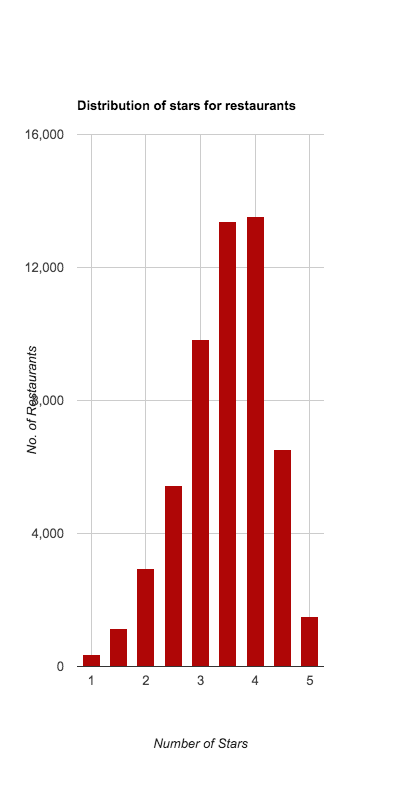

In [24]:
%%chart columns --data star_distribution

title: Distribution of stars for restaurants 
height: 800
hAxis:
  title: Number of Stars
vAxis:
  title: No. of Restaurants
legend: 'none'
colors: ['af0606']

This chart shows us that most restaurants fall between 3 to 4.5 stars.

In [8]:
%%bq query

SELECT ROUND(avg(stars),1) AS avg_stars
FROM `team-8-bs-770-b.Yelp.Yelp_business`
WHERE categories LIKE ("%Restaurants%")

avg_stars
3.5


On further calculation, we found out that the **average star rating** for restaurants around the world is **3.5.**

## <font color='af0606'>Choosing the top 3 cities to open restaurants in:</font>

In [12]:
%%bq query -n Most_Visited_Cities_Restaurants

SELECT city,average_checkins
FROM `team-8-bs-770-b.Saved_queries.chosen_cities`
ORDER BY average_checkins DESC
limit 5

# This Query selects the city and their respective average check-ins per restaurant per week.
# It then organizes the data by average check-ins per restaurant in descending order.
# We will easily see which 5 cities have the most number of average check-ins per week.


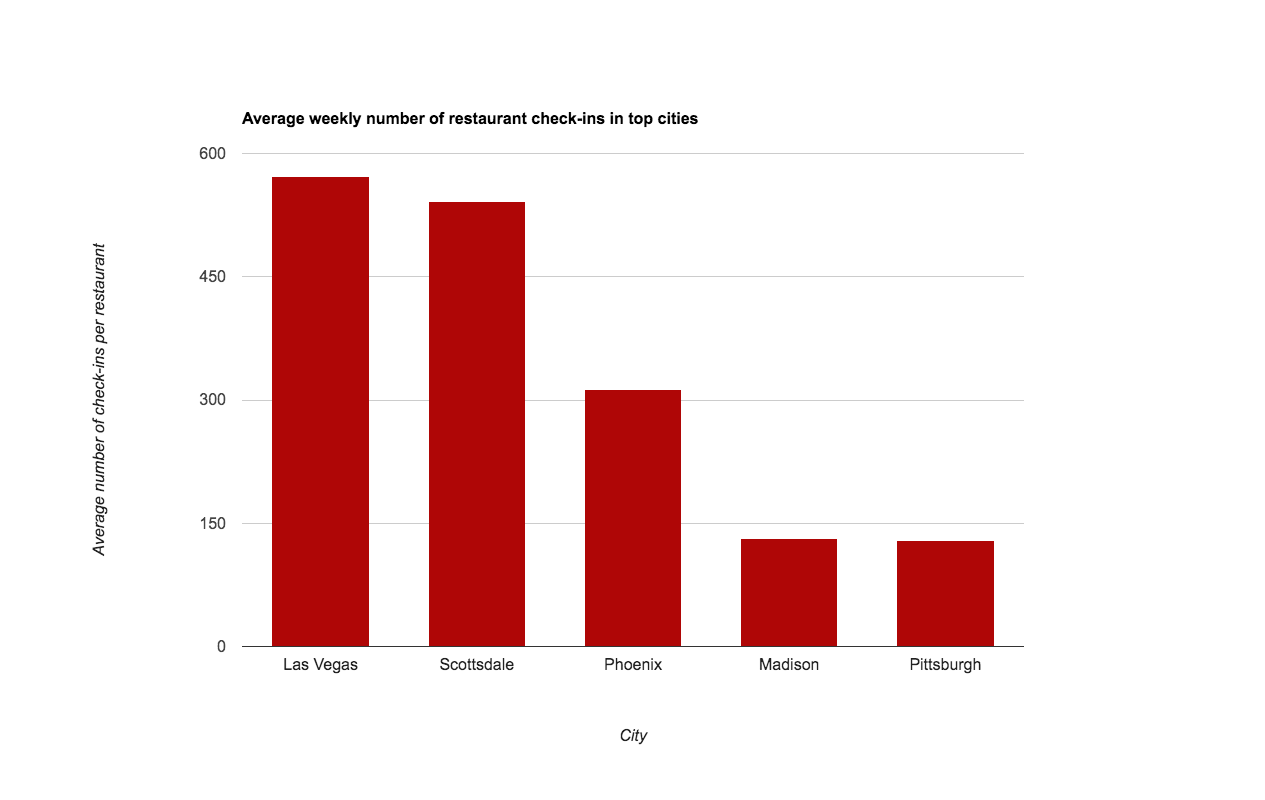

In [17]:
%%chart columns --data Most_Visited_Cities_Restaurants

title: Average weekly number of restaurant check-ins in top cities
height: 800
hAxis: 
 title: 'City'
vAxis: 
 title: 'Average number of check-ins per restaurant'
legend: 'none'
colors: ['af0606']

We created a columns chart to visualize the variation in check-ins for each of the cities. We plotted the city names on the x-axis and the average check-in per restaurant on the y-axis. Since the data was organized by the average check-ins per restaurants per week in descending order, we can conclude that the 5 cities shown above have the most check-in per restaurant, and from these, we narrowed our scope down to 3 cities, namely: **Las Vegas, Scottsdate and Phoenix**. These are the cities our team decided to further investigate and open restaurants in, as it shows that there is a significant demand for restaurants in general in these 3 cities. 

## <font color='af0606'>Choosing top tags (attributes and cuisines) for Las Vegas:</font>

In [1]:
%%bq query

SELECT string_field_0 AS category, COUNT(string_field_0) AS category_count
FROM (SELECT
    business_id,
    name,
    SPLIT(categories,";") AS category
    FROM
    `team-8-bs-770-b.Yelp.Yelp_business`
    WHERE city = 'Las Vegas' AND categories LIKE '%Restaurants%'),
  UNNEST( category ) AS string_field_0
WHERE string_field_0 NOT IN ('Restaurants', 'Food')
GROUP BY category
ORDER BY category_count DESC
LIMIT 10


# First, we use this code snippet to figure out the top 10 tags that appear most often in Las Vegas.

category,category_count
Fast Food,884
Nightlife,808
American (Traditional),774
Bars,763
Mexican,758
Sandwiches,655
Pizza,613
American (New),574
Burgers,531
Chinese,429


In [10]:
%%bq query --n top_tags_for_lasvegas

SELECT
  each_cat,
  ROUND((SUM(total_checkins)/ COUNT(business_id)),2) AS avg_checkins_per_category
FROM
  `team-8-bs-770-b.Final_Tables.LasVegas_Final`
WHERE
  each_cat IN ('Fast Food',
    'Nightlife',
    'American (Traditional)',
    'Bars',
    'Mexican',
    'Sandwiches',
    'Pizza',
    'American (NEW)',
    'Burgers',
    'Chinese')
GROUP BY
  each_cat
HAVING
  AVG(stars) > 3.5
ORDER BY
  avg_checkins_per_category DESC

# Next, we are trying to find out which tags, amongst the top 10 most frequently occurring tags, help restaurants perform well in Las Vegas.
 
# Our definition for good performance = having the highest number of average checkins per week & higher than average star ratings (3.5).

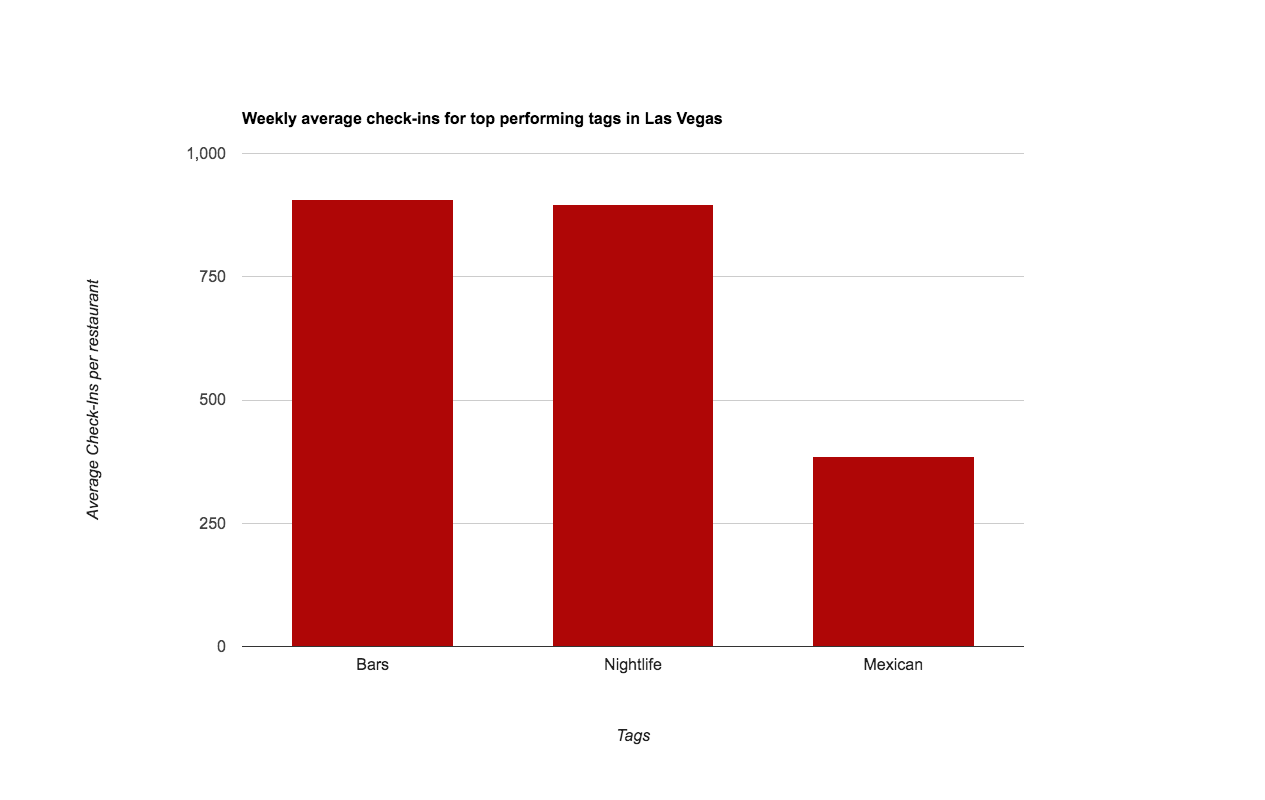

In [64]:
%%chart columns --data top_tags_for_lasvegas

title: 'Weekly average check-ins for top performing tags in Las Vegas'
height: 800
hAxis: 
 title: 'Tags'
vAxis: 
 title: 'Average Check-Ins per restaurant'
legend: 'none'
colors: ['af0606']

From the graph above, we can see that in Las Vegas, restaurants that usually perform well are the ones which boast these 3 tags: **"Bars", "Nightlife"** and **"Mexican"**.

**Thus, we recommend a restaurant which would serve Mexican food, have a bar and host nightlife.**

## <font color='af0606'>Choosing top tags (attributes and cuisines) for Phoenix:</font>

In [2]:
%%bq query 

SELECT string_field_0 AS category, COUNT(string_field_0) AS category_count
FROM (SELECT
    business_id,
    name,
    SPLIT(categories,";") AS category
    FROM
    `team-8-bs-770-b.Yelp.Yelp_business`
    WHERE city = 'Phoenix' AND categories LIKE '%Restaurants%'),
  UNNEST( category ) AS string_field_0
WHERE string_field_0 NOT IN ('Restaurants', 'Food')
GROUP BY category
ORDER BY category_count DESC
LIMIT 10

# First, we use this code snippet to figure out the top 10 tags that appear most often in Phoenix.

category,category_count
Mexican,677
Fast Food,585
Sandwiches,561
American (Traditional),475
Nightlife,435
Bars,418
Pizza,414
Breakfast & Brunch,377
Burgers,367
American (New),362


In [19]:
%%bq query --n top_tags_for_phoenix

SELECT
  category,
  ROUND((SUM(total_checkins)/ COUNT(business_id)),2) AS avg_checkins_per_category
FROM
  `team-8-bs-770-b.Categories_By_City.Phoenix_in_process2`
WHERE
  category IN ('Mexican',
    'Fast Food',
    'Sandwiches',
    'American (Traditional)',
    'Nightlife',
    'Bars',
    'Pizza',
    'Breakfast & Brunch',
    'Burgers',
    'American (New)')
GROUP BY
  category
HAVING
  AVG(stars) > 3.5
ORDER BY
  avg_checkins_per_category DESC

# Next, we are trying to find out which tags, amongst the top 10 most frequently occurring tags, help restaurants perform well in Phoenix.
 
# Our definition for good performance = having the highest number of average checkins per week & higher than average star ratings (3.5).

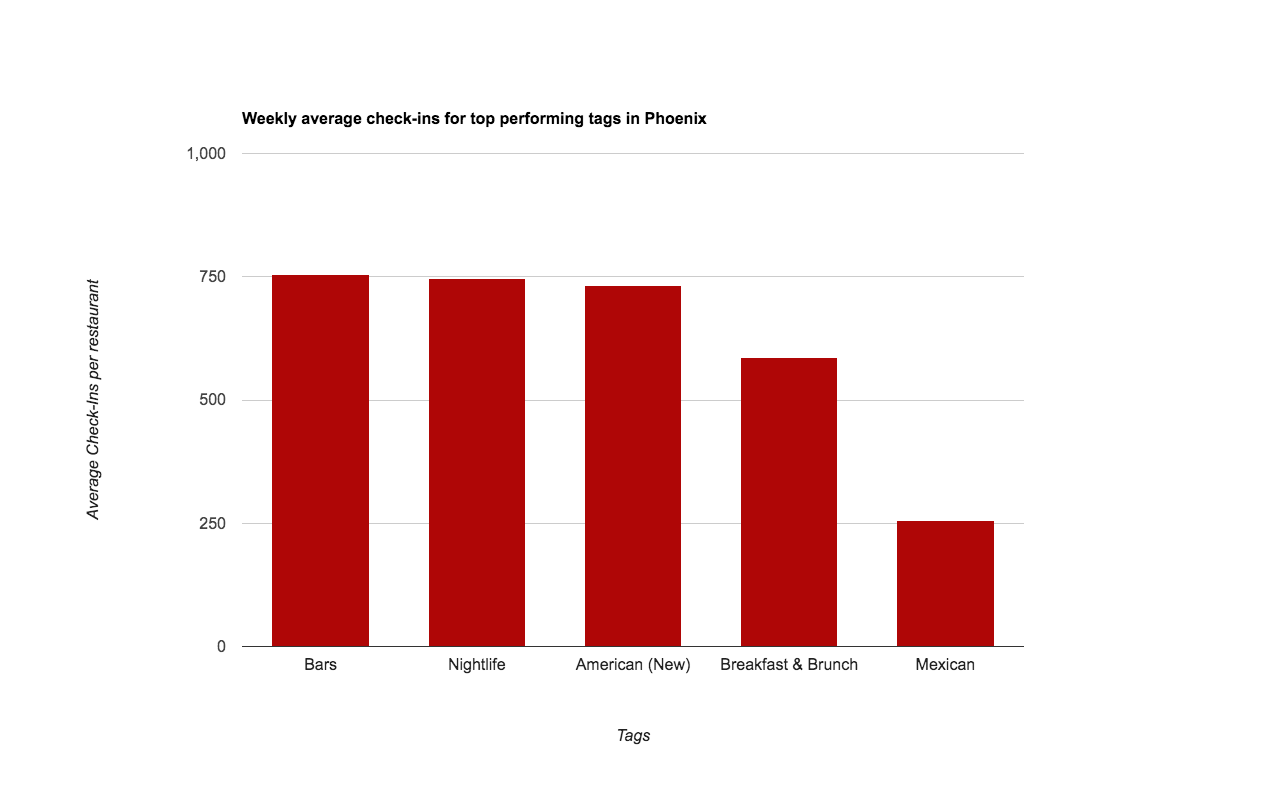

In [63]:
%%chart columns --data top_tags_for_phoenix

title: 'Weekly average check-ins for top performing tags in Phoenix'
height: 800
hAxis: 
 title: 'Tags'
vAxis: 
 title: 'Average Check-Ins per restaurant'
legend: 'none'
colors: ['af0606']

From the graph above, we can see that in Phoenix, restaurants that usually perform well are the ones which boast these 5 tags: **"Bars", "Nightlife", "American(new)", "Breakfast & Brunch" and "Mexican"**.

**Thus, we recommend a restaurant which would serve either Mexican or American food, have a bar, host nightlife and have an option of serving Breakfast/Brunch.**

## <font color='af0606'>Choosing top tags (attributes and cuisines) for Scottsdale:</font>

In [3]:
%%bq query

SELECT string_field_0 AS category, COUNT(string_field_0) AS category_count
FROM (SELECT
    business_id,
    name,
    SPLIT(categories,";") AS category
    FROM
    `team-8-bs-770-b.Yelp.Yelp_business`
    WHERE city = 'Scottsdale' AND categories LIKE '%Restaurants%'),
  UNNEST( category ) AS string_field_0
WHERE string_field_0 NOT IN ('Restaurants', 'Food')
GROUP BY category
ORDER BY category_count DESC
LIMIT 10
# First, we use this code snippet to figure out the top 10 tags that appear most often in Scottsdale.

category,category_count
Nightlife,342
Bars,331
American (New),286
Sandwiches,239
American (Traditional),225
Breakfast & Brunch,190
Italian,169
Pizza,161
Fast Food,152
Mexican,146


In [22]:
%%bq query --n top_tags_for_scottsdale

SELECT
  each_cat,
  ROUND((SUM(total_checkins)/ COUNT(business_id)),2) AS avg_checkins_per_category
FROM
  `team-8-bs-770-b.Categories_By_City.Scottsdale_in_process2`
WHERE
  each_cat IN ('Mexican',
    'Fast Food',
    'Sandwiches',
    'American (Traditional)',
    'Nightlife',
    'Bars',
    'Pizza',
    'Breakfast & Brunch',
    'Italian',
    'American (New)')
GROUP BY
  each_cat
HAVING
  AVG(stars) > 3.5
ORDER BY
  avg_checkins_per_category DESC

# Next, we are trying to find out which tags, amongst the top 10 most frequently occurring tags, help restaurants perform well in Scottsdale.
 
# Our definition for good performance = having the highest number of average checkins per week & higher than average star ratings (3.5).


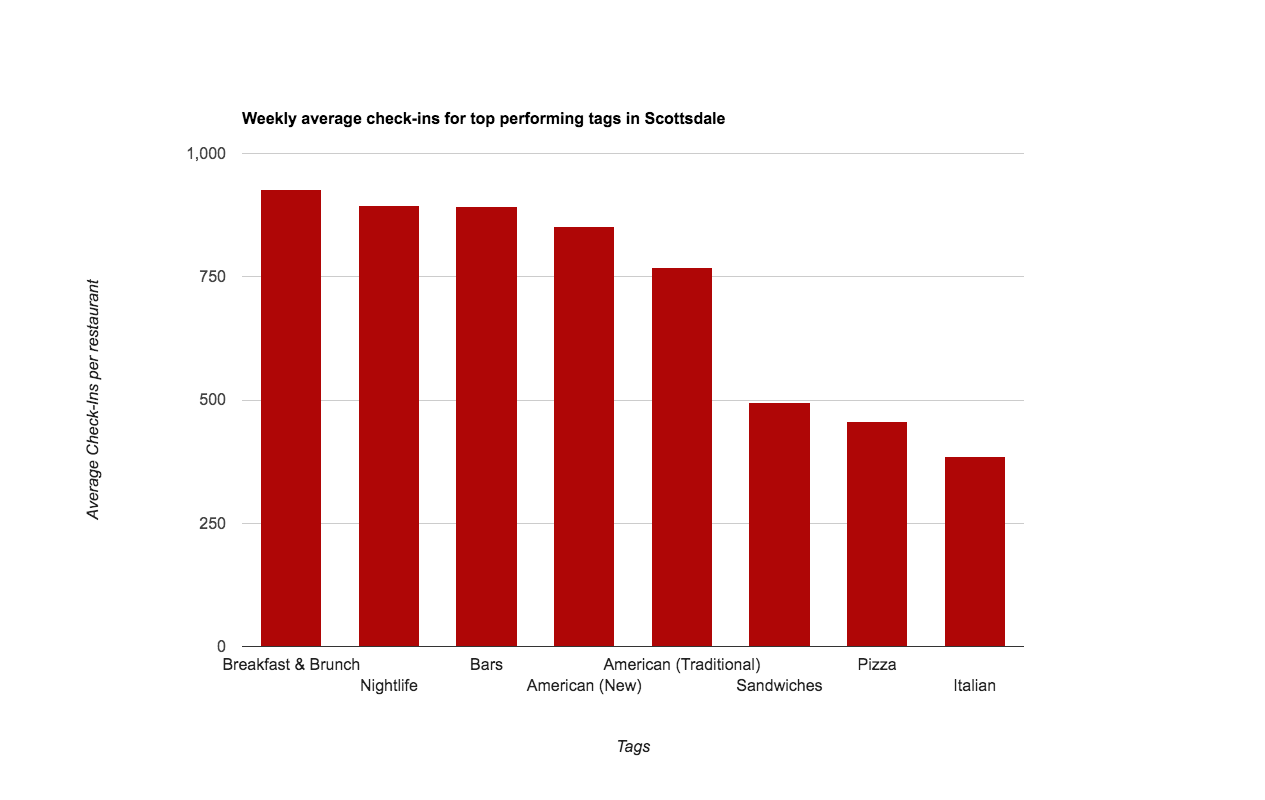

In [62]:
%%chart columns --data top_tags_for_scottsdale

title: 'Weekly average check-ins for top performing tags in Scottsdale'
height: 800
hAxis: 
 title: 'Tags'
vAxis: 
 title: 'Average Check-Ins per restaurant'
legend: 'none'
colors: ['af0606']

From the graph above, we can see that in Phoenix, restaurants that usually perform well are the ones which boast these 5 tags: **"Breakfast & Brunch", "Nightlife", "Bars", "American(new)", "American (Traditional)", "Sandwiches", "Pizza" and "Italian"**.

**Thus, we recommend a restaurant which would preferably serve American food or alternatively, Italian food, have a bar, host nightlife and most importantly, serve Breakfast/Brunch.**

## <font color='af0606'>Offering what attributes/services increases average star rating for restaurants round the world?</font>

In [14]:
%%bq query --n star_attribute

SELECT 'all_false' AS attributes, AVG(stars) AS avg_star
FROM `team-8-bs-770-b.attributes_new.8_attributes_cleaned`
WHERE BusinessAcceptsCreditCards = FALSE
AND BusinessParking_garage = FALSE
AND WheelchairAccessible = FALSE
AND BikeParking = FALSE
AND Alcohol = FALSE
AND HappyHour = FALSE
AND OutdoorSeating = FALSE
UNION ALL
SELECT 'BusinessAcceptsCreditCards' AS attributes , AVG(stars) AS avg_star
FROM `team-8-bs-770-b.attributes_new.8_attributes_cleaned`
WHERE BusinessAcceptsCreditCards = TRUE
UNION ALL
SELECT 'BusinessParking_garage' AS attributes , AVG(stars) AS avg_star
FROM `team-8-bs-770-b.attributes_new.8_attributes_cleaned`
WHERE BusinessParking_garage = TRUE
UNION ALL
SELECT 'WheelchairAccessible' AS attributes , AVG(stars) AS avg_star
FROM `team-8-bs-770-b.attributes_new.8_attributes_cleaned`
WHERE WheelchairAccessible = TRUE
UNION ALL
SELECT 'BikeParking' AS attributes , AVG(stars) AS avg_star
FROM `team-8-bs-770-b.attributes_new.8_attributes_cleaned`
WHERE BikeParking = TRUE
UNION ALL
SELECT 'Alcohol' AS attributes , AVG(stars) AS avg_star
FROM `team-8-bs-770-b.attributes_new.8_attributes_cleaned`
WHERE Alcohol = TRUE
UNION ALL
SELECT 'HappyHour' AS attributes , AVG(stars) AS avg_star
FROM `team-8-bs-770-b.attributes_new.8_attributes_cleaned`
WHERE HappyHour = TRUE
UNION ALL
SELECT 'OutdoorSeating' AS attributes , AVG(stars) AS avg_star
FROM `team-8-bs-770-b.attributes_new.8_attributes_cleaned`
WHERE OutdoorSeating = TRUE
ORDER BY avg_star DESC

The query above selects the star rating for the restaurants where only one attribute/service is provided (TRUE), while others are kept constant at FALSE.

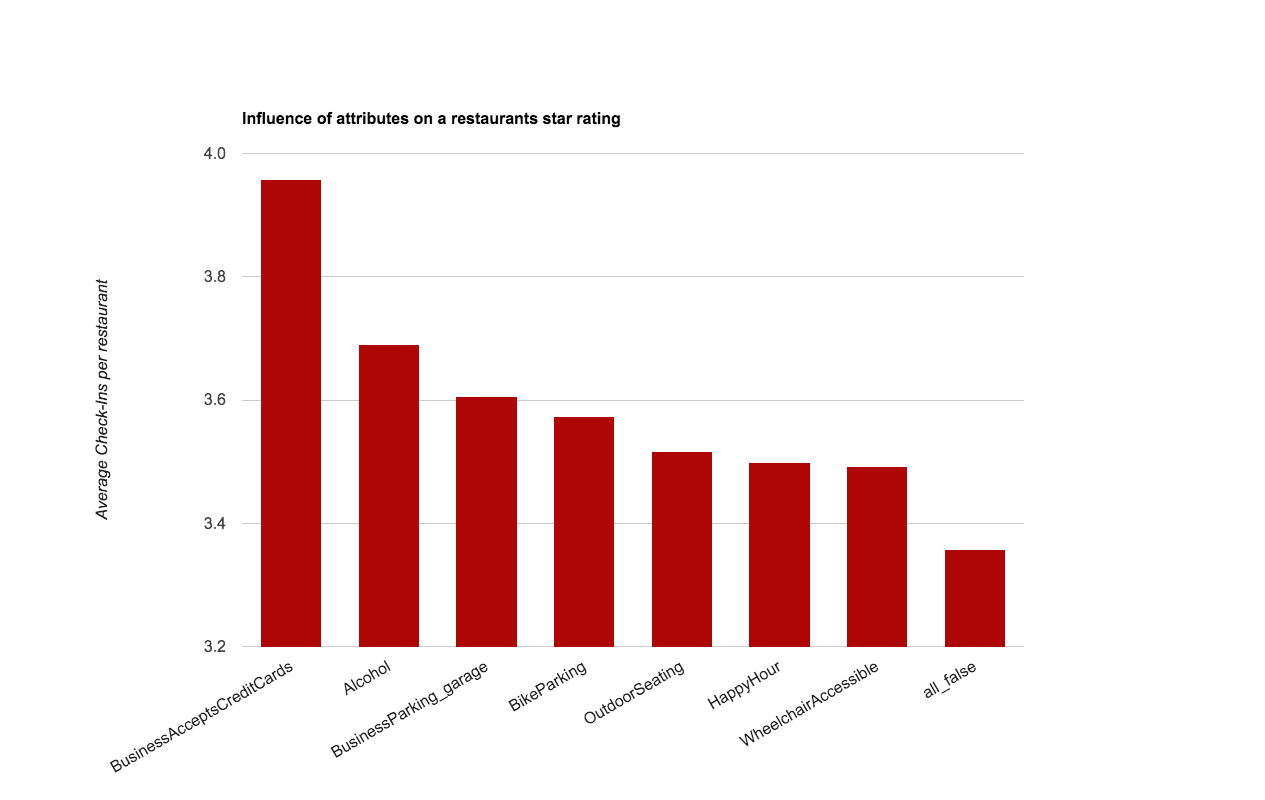

In [22]:
%%chart columns --data star_attribute

title: 'Influence of attributes on a restaurants star rating'
height: 800
hAxis: 
 title: 
vAxis: 
 title: 'Average Check-Ins per restaurant'
legend: 'none'
colors: ['af0606']

Apart from personalized recommendations for each city, we studied eight attributes/services - which when provided - help a restaurant perform better, globally.

We analyzed them to find out the extent to which each attribute contributed to the star ratings.

**The results show that the attribute pertaining to businesses accepting credit cards as payment, has the biggest influence on the star rating, followed by their ability to provide “alcohol” and a “parking garage”, while the presence of “wheelchair accessibility” almost has no contribution to the star rating.**


## <font color='af0606'>Most frequently occuring words in reviews</font>

We separated the review words into two groups, those which were in the “bad reviews”, the customers who wrote these gave the restaurant 1 or 2 stars and “good reviews” these customers gave 4 or 5 stars.

In [9]:
%%bq query
SELECT count(words) repetition, Description
FROM `team-8-bs-770-b.Saved_queries.ReviewSplit` 
 , UNNEST(words ) as Description
group by Description,stars
having stars=1 or stars=2
order by repetition desc

repetition,Description
1855059,the
1827348,the
1402665,and
1246064,and
1221039,to
1100597,I
986903,to
975064,I
970725,a
961279,was


In [8]:
%%bq query
SELECT count(words) repetition, Description
FROM `team-8-bs-770-b.Saved_queries.ReviewSplit` 
 , UNNEST(words ) as Description
group by Description,stars
having stars=4 or stars=5
order by repetition desc

repetition,Description
4413477,the
4241636,the
3993442,and
3382928,and
2716909,a
2509029,a
2222617,I
2125090,I
2091703,to
1937153,to


Once this was done we used another software to clean the data, eliminate connectors, to highlight the words which are most commonly used in each type of reviews respectively - the good and the bad. These reults were used to come up with 2 word clouds - one showing the most frequently occuring words in 4-5 star reviews, and the other showing the most frequently occuring words in 1-2 star reviews.